In [ ]:
!pip install torch torchvision numpy tqdm matplotlib pandas git+https://github.com/RobustBench/robustbench.git

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/RobustBench/robustbench.git to /scratch/yjabary/apptainer_env/venv/.local/pip-req-build-4r9ui924
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /scratch/yjabary/apptainer_env/venv/.local/pip-req-build-4r9ui924
  Resolved https://github.com/RobustBench/robustbench.git to commit 776bc95bb4167827fb102a32ac5aea62e46cfaab
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fra31/auto-attack.git (to revision a39220048b3c9f2cca9a4d3a54604793c68eca7e) to /scratch/yjabary/apptainer_env/venv/.local/pip-install-f9xp7vxk/autoattack_cbc2b2df13984972ac1697e68aea04a0
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack.git /scratch/yjabary/apptainer_env/venv/.local/pip-install-f9xp7vxk/autoattack_cbc2b2df13984972ac1697e68aea04a0
  Running command git rev-parse -q --verify 'sha^a39220048b3c9

/scratch/yjabary/apptainer_env/venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169M/169M [00:06<00:00, 27.8MB/s]


Extracting /scratch/yjabary/self-ensembling/datasets/cifar-100-python.tar.gz to /scratch/yjabary/self-ensembling/datasets
Files already downloaded and verified


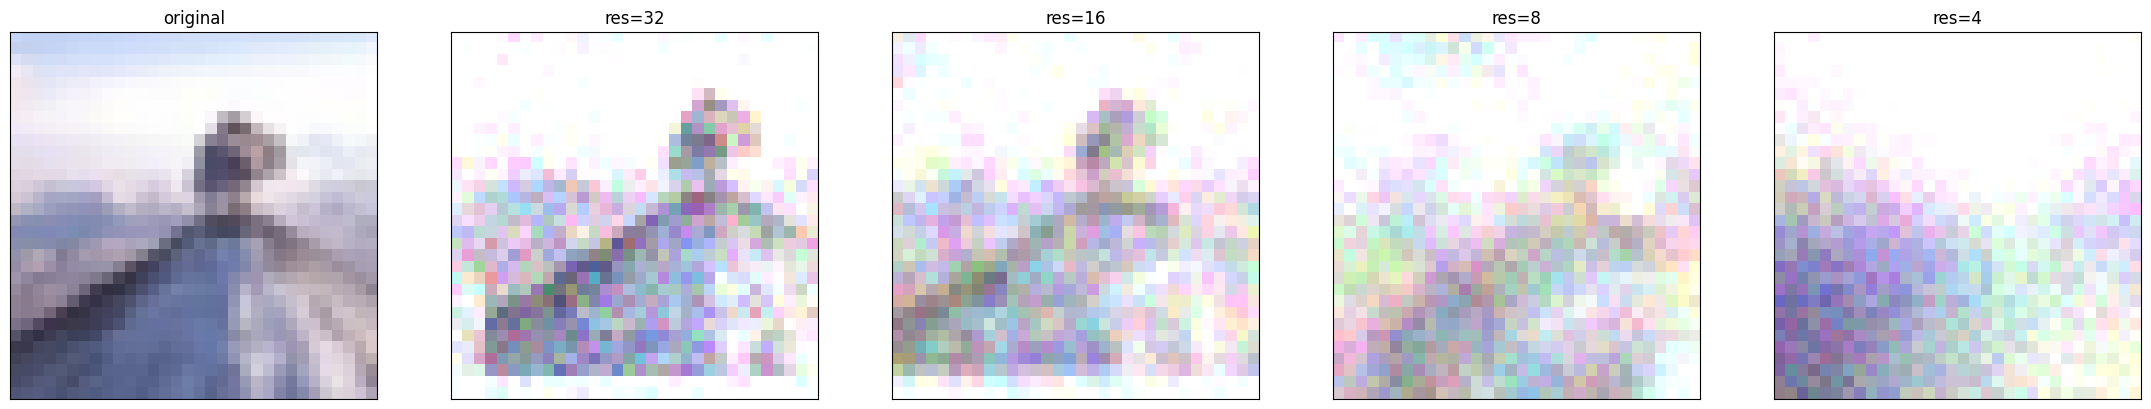

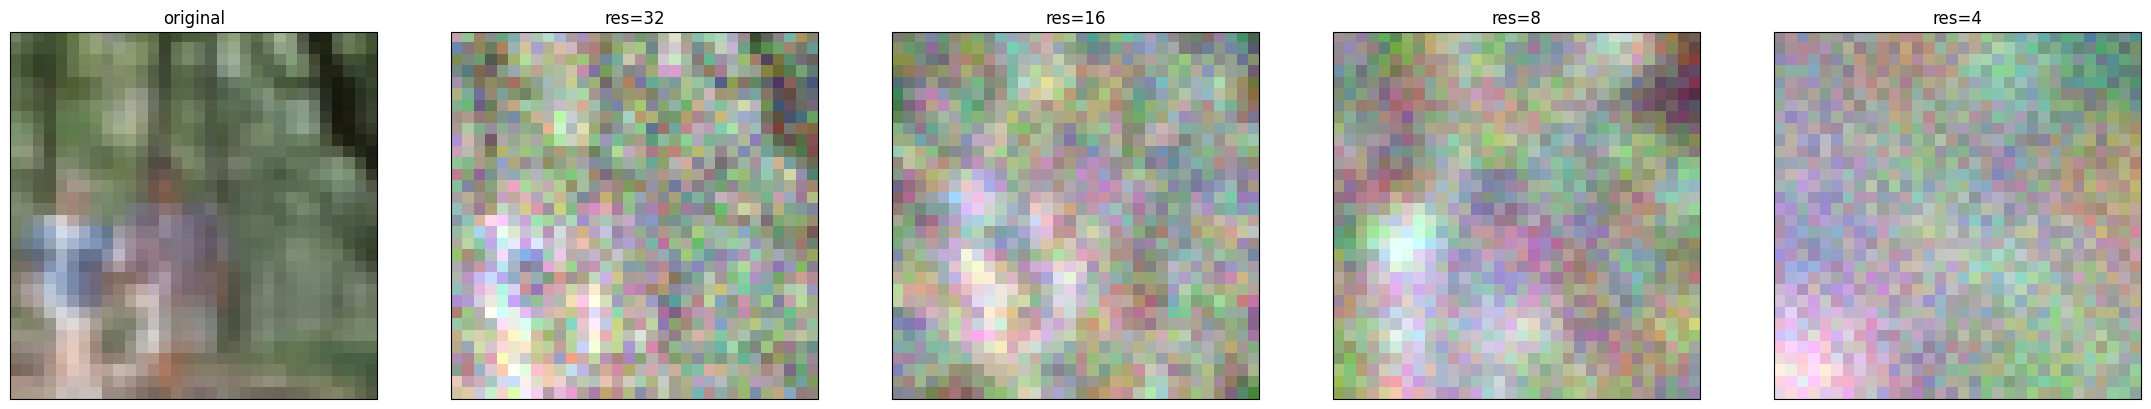

In [ ]:
import copy
import gc
import os
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

import random
import hashlib
import time
import copy

import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import *

assert torch.cuda.is_available()
gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
assert gpu_memory >= 79, "at least 80GB gpu memory required"

set_env()


#
# data
#


classes_path = get_current_dir().parent / "data"
dataset_path = get_current_dir().parent / "datasets"
weights_path = get_current_dir().parent / "weights"

os.makedirs(classes_path, exist_ok=True)
os.makedirs(dataset_path, exist_ok=True)
os.makedirs(weights_path, exist_ok=True)


classes = 100
assert classes == 100

if classes == 10:
    trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=True)
    testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=True)

    original_images_train_np = np.array(trainset.data)
    original_labels_train_np = np.array(trainset.targets)

    original_images_test_np = np.array(testset.data)
    original_labels_test_np = np.array(testset.targets)

elif classes == 100:
    trainset = torchvision.datasets.CIFAR100(root=dataset_path, train=True, download=True)
    testset = torchvision.datasets.CIFAR100(root=dataset_path, train=False, download=True)

    original_images_train_np = np.array(trainset.data)
    original_labels_train_np = np.array(trainset.targets)

    original_images_test_np = np.array(testset.data)
    original_labels_test_np = np.array(testset.targets)

# images between 0 and 1 instead of 0 and 255

images_train_np = original_images_train_np / 255.0
images_test_np = original_images_test_np / 255.0

labels_train_np = original_labels_train_np
labels_test_np = original_labels_test_np


#
# preprocessing
#


resolutions = [32, 16, 8, 4]  # pretty arbitrary
down_noise = 0.2  # noise standard deviation to be added at the low resolution
up_noise = 0.2  # noise stadard deviation to be added at the high resolution
jit_size = 3  # max size of the x-y jit in each axis, sampled uniformly from -jit_size to +jit_size inclusive
up_res = 32  # hard coded for CIFAR-10 or CIFAR-100
shuffle_image_versions_randomly = False  # to shuffle randomly which image is which in the multi-res stack (false in paper)


def default_make_multichannel_input(images):  # don't do anything
    return torch.concatenate([images] * len(resolutions), axis=1)


def make_multichannel_input(images):
    all_channels = []

    for i, r in enumerate(resolutions):

        def apply_transformations(images, down_res, up_res, jit_x, jit_y, down_noise, up_noise, contrast, color_amount):
            # images = torch.mean(images,axis=1,keepdims=True) # only for mnist

            images_collected = []
            for i in range(images.shape[0]):
                image = images[i]
                image = torchvision.transforms.functional.adjust_contrast(image, contrast[i])  # changing contrast
                image = torch.roll(image, shifts=(jit_x[i], jit_y[i]), dims=(-2, -1))  # shift the result in x and y
                image = color_amount[i] * image + torch.mean(image, axis=0, keepdims=True) * (1 - color_amount[i])  # shifting in the color <-> grayscale axis
                images_collected.append(image)
            images = torch.stack(images_collected, axis=0)

            images = F.interpolate(images, size=(down_res, down_res), mode="bicubic")  # descrease the resolution

            noise = down_noise * torch.Tensor(np.random.rand(images.shape[0], 3, down_res, down_res)).to("cuda")  # low res noise
            images = images + noise

            images = F.interpolate(images, size=(up_res, up_res), mode="bicubic")  # increase the resolution

            noise = up_noise * torch.Tensor(np.random.rand(images.shape[0], 3, up_res, up_res)).to("cuda")  # high res noise
            images = images + noise

            images = torch.clip(images, 0, 1)  # clipping to the right range of values
            return images

        images_now = apply_transformations(
            images,
            down_res=r,
            up_res=up_res,
            jit_x=np.random.choice(range(-jit_size, jit_size + 1), len(images + i)),  # x-shift,
            jit_y=np.random.choice(range(-jit_size, jit_size + 1), len(51 * images + 7 * i + 125 * r)),  # y-shift
            down_noise=down_noise,
            up_noise=up_noise,
            contrast=np.random.choice(np.linspace(0.7, 1.5, 100), len(7 + 3 * images + 9 * i + 5 * r)),  # change in contrast,
            color_amount=np.random.choice(np.linspace(0.5, 1.0, 100), len(5 + 7 * images + 8 * i + 2 * r)),  # change in color amount
        )

        all_channels.append(images_now)

    if not shuffle_image_versions_randomly:
        return torch.concatenate(all_channels, axis=1)
    elif shuffle_image_versions_randomly:
        indices = torch.randperm(len(all_channels))
        shuffled_tensor_list = [all_channels[i] for i in indices]
        return torch.concatenate(shuffled_tensor_list, axis=1)


plot = True
if plot:
    sample_images = images_test_np[:5]
    for j in [0, 1]:
        multichannel_images = make_multichannel_input(torch.Tensor(sample_images.transpose([0, 3, 1, 2])).to("cuda")).detach().cpu().numpy().transpose([0, 2, 3, 1])
        N = 1 + multichannel_images.shape[3] // 3
        plt.figure(figsize=(N * 5.5, 5))
        plt.subplot(1, N, 1)
        plt.title("original")
        plt.imshow(sample_images[j])
        plt.xticks([], [])
        plt.yticks([], [])
        for i in range(N - 1):
            plt.subplot(1, N, i + 2)
            plt.title(f"res={resolutions[i]}")
            plt.imshow(multichannel_images[j, :, :, 3 * i : 3 * (i + 1)])
            plt.xticks([], [])
            plt.yticks([], [])
        plt.show()

In [ ]:
# 
# train and eval
# 

def eval_model(model, images_in, labels_in, batch_size=128):
    all_preds = []
    all_logits = []

    with torch.no_grad():
        its = int(np.ceil(float(len(images_in)) / float(batch_size)))

        pbar = tqdm(range(its), desc="eval", ncols=100)

        for it in pbar:
            i1 = it * batch_size
            i2 = min([(it + 1) * batch_size, len(images_in)])

            inputs = torch.Tensor(images_in[i1:i2].transpose([0, 3, 1, 2])).to("cuda")
            outputs = model(inputs)

            all_logits.append(outputs.detach().cpu().numpy())

            preds = torch.argmax(outputs, axis=-1)
            all_preds.append(preds.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_logits = np.concatenate(all_logits, axis=0)

    return np.sum(all_preds == labels_in), all_preds.shape[0], all_logits


def fgsm_attack(model, xs, ys, epsilon, random_reps=1, batch_size=64):
    model = model.eval()

    all_perturbed_images = []

    its = int(np.ceil(xs.shape[0] / batch_size))
    for it in range(its):
        i1 = it * batch_size
        i2 = min([(it + 1) * batch_size, xs.shape[0]])

        x = torch.Tensor(xs[i1:i2].transpose([0, 3, 1, 2])).to("cuda")
        y = torch.Tensor(ys[i1:i2]).to("cuda").to(torch.long)
        x.requires_grad = True

        for _ in range(random_reps):
            outputs = model(x)
            loss = nn.CrossEntropyLoss()(outputs, y)
            loss.backward()

        perturbed_image = x + epsilon * x.grad.data.sign()
        perturbed_image = torch.clip(perturbed_image, 0, 1)
        all_perturbed_images.append(perturbed_image.detach().cpu().numpy().transpose([0, 2, 3, 1]))
    return np.concatenate(all_perturbed_images, axis=0)


def train_model(
    model_in,
    images_in,
    labels_in,
    epochs=10,
    lr=1e-3,
    batch_size=512,
    optimizer_in=optim.Adam,
    subset_only=None,
    mode="eval",
    use_adversarial_training=False,
    adversarial_epsilon=8 / 255,
    skip_test_set_eval=False,
):
    global storing_models

    if mode == "train":
        model_in.train()
    elif mode == "eval":
        model_in.eval()

    criterion = nn.CrossEntropyLoss()

    if subset_only is None:
        train_optimizer = optimizer_in(model_in.parameters(), lr=lr)
    else:
        train_optimizer = optimizer_in(subset_only, lr=lr)

    for epoch in range(epochs):
        if mode == "train":  # avoid random flips
            model_in.train()
        elif mode == "eval":
            model_in.eval()
        else:
            assert False

        all_hits = []

        randomized_ids = np.random.permutation(range(len(images_in)))
        its = int(np.ceil(float(len(images_in)) / float(batch_size)))
        pbar = tqdm(range(its), desc="Training", ncols=100)
        for it in pbar:
            i1 = it * batch_size
            i2 = min([(it + 1) * batch_size, len(images_in)])

            np_images_used = images_in[randomized_ids[i1:i2]]
            np_labels_used = labels_in[randomized_ids[i1:i2]]

            # very light adversarial training if on (off by default)
            if use_adversarial_training:
                attacked_images = fgsm_attack(model_in.eval(), np_images_used[:], np_labels_used[:], epsilon=adversarial_epsilon, random_reps=1, batch_size=batch_size // 2)
                np_images_used = attacked_images
                np_labels_used = np_labels_used
                if mode == "train":
                    model_in.train()
                elif mode == "eval":
                    model_in.eval()

            inputs = torch.Tensor(np_images_used.transpose([0, 3, 1, 2])).to("cuda")
            labels = torch.Tensor(np_labels_used).to("cuda").to(torch.long)

            # the actual optimization step
            train_optimizer.zero_grad()
            outputs = model_in(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            train_optimizer.step()

            # on the fly eval for the train set batches
            preds = torch.argmax(outputs, axis=-1)
            acc = torch.mean((preds == labels).to(torch.float), axis=-1)
            all_hits.append((preds == labels).to(torch.float).detach().cpu().numpy())
            train_accs.append(acc.detach().cpu().numpy())

            pbar.set_description(f"train acc={acc.detach().cpu().numpy()} loss={loss.item()}")

        if not skip_test_set_eval:
            with isolated_environment():
                eval_model_copy = copy.deepcopy(model_in)
                test_hits, test_count, _ = eval_model(eval_model_copy.eval(), images_test_np, labels_test_np)

        # end of epoch eval
        train_hits = np.sum(np.concatenate(all_hits, axis=0).reshape([-1]))
        train_count = np.concatenate(all_hits, axis=0).reshape([-1]).shape[0]
        print(f"e={epoch} train {train_hits} / {train_count} = {train_hits/train_count},  test {test_hits} / {test_count} = {test_hits/test_count}")

        test_accs.append((test_hits / test_count) if (test_count > 0) else 0)

    print("done")
    return model_in


#
# backbone training
#

from torchvision.models import resnet152, ResNet152_Weights

imported_model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

in_planes = 3
planes = 64
stride = 2
N = len(resolutions)  # input channels multiplier due to multi-res input

conv2 = nn.Conv2d(N * in_planes, planes, kernel_size=7, stride=stride, padding=3, bias=False)
imported_model.conv1 = copy.deepcopy(conv2)  # replace the first conv layer with new multi-res one
imported_model.fc = nn.Linear(2048, classes)  # set num of classes in final layer


class ImportedModelWrapper(nn.Module):
    def __init__(self, imported_model, multichannel_fn):
        super(ImportedModelWrapper, self).__init__()
        self.imported_model = imported_model
        self.multichannel_fn = multichannel_fn

    def forward(self, x):
        x = self.multichannel_fn(x)  # preprocess
        x = F.interpolate(x, size=(224, 224), mode="bicubic")
        x = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406] * (x.shape[1] // 3), std=[0.229, 0.224, 0.225] * (x.shape[1] // 3))(x)
        x = self.imported_model(x)
        return x


wrapped_model = ImportedModelWrapper(imported_model, make_multichannel_input).to("cuda")
wrapped_model.multichannel_fn = make_multichannel_input
model = copy.deepcopy(wrapped_model)
model.multichannel_fn = make_multichannel_input
model.train()

train_accs = []
test_accs = []

torch.cuda.empty_cache()
device = torch.device("cuda:0")
# with torch.autocast("cuda"):
model = train_model(
    model,
    images_train_np,
    labels_train_np,
    epochs=6,
    lr=3.3e-5,  # simple grid search, likely not optimal
    optimizer_in=optim.Adam,
    batch_size=128,
    mode="train",
)


# backbone_path = weights_path / "checkpoint_backbone.pth"
# if backbone_path.exists():
#     model.load_state_dict(torch.load(backbone_path))
#     model = model.to(device)
#     model = model.train()
#     print("loaded model")
# else:
#     model = train_model(
#         model,
#         images_train_np,
#         labels_train_np,
#         epochs=6,
#         lr=3.3e-5,
#         optimizer_in=optim.Adam,
#         batch_size=128,
#         mode="train",
#     )
#     torch.save(model.state_dict(), backbone_path)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /scratch/yjabary/apptainer_env/torch_cache/hub/checkpoints/resnet152-f82ba261.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230M/230M [00:00<00:00, 315MB/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:17<00:00,  4.60it/s]


e=0 train 3100.0 / 50000 = 0.06199999898672104,  test 1408 / 10000 = 0.1408


train acc=0.2750000059604645 loss=2.799875259399414: 100%|████████| 391/391 [02:51<00:00,  2.27it/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:17<00:00,  4.56it/s]


e=1 train 11325.0 / 50000 = 0.226500004529953,  test 3157 / 10000 = 0.3157


train acc=0.4000000059604645 loss=2.1474509239196777: 100%|███████| 391/391 [02:51<00:00,  2.29it/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.85it/s]


e=2 train 19513.0 / 50000 = 0.3902600109577179,  test 4467 / 10000 = 0.4467


train acc=0.612500011920929 loss=1.7065765857696533: 100%|████████| 391/391 [02:51<00:00,  2.28it/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.29it/s]


e=3 train 24799.0 / 50000 = 0.49597999453544617,  test 5103 / 10000 = 0.5103


train acc=0.5875000357627869 loss=1.5127522945404053: 100%|███████| 391/391 [02:51<00:00,  2.28it/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.09it/s]


e=4 train 28234.0 / 50000 = 0.5646799802780151,  test 5613 / 10000 = 0.5613


train acc=0.675000011920929 loss=1.0542172193527222: 100%|████████| 391/391 [02:52<00:00,  2.27it/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:16<00:00,  4.68it/s]

e=5 train 30811.0 / 50000 = 0.6162199974060059,  test 5889 / 10000 = 0.5889

Finished Training


layer=0 torch.Size([2, 100])
layer=1 torch.Size([2, 100])
layer=2 torch.Size([2, 100])
layer=3 torch.Size([2, 100])
layer=4 torch.Size([2, 100])
layer=5 torch.Size([2, 100])
layer=6 torch.Size([2, 100])
layer=7 torch.Size([2, 100])
layer=8 torch.Size([2, 100])
layer=9 torch.Size([2, 100])
layer=10 torch.Size([2, 100])
layer=11 torch.Size([2, 100])
layer=12 torch.Size([2, 100])
layer=13 torch.Size([2, 100])
layer=14 torch.Size([2, 100])
layer=15 torch.Size([2, 100])
layer=16 torch.Size([2, 100])
layer=17 torch.Size([2, 100])
layer=18 torch.Size([2, 100])
layer=19 torch.Size([2, 100])
layer=20 torch.Size([2, 100])
layer=21 torch.Size([2, 100])
layer=22 torch.Size([2, 100])
layer=23 torch.Size([2, 100])
layer=24 torch.Size([2, 100])
layer=25 torch.Size([2, 100])
layer=26 torch.Size([2, 100])
layer=27 torch.Size([2, 100])
layer=28 torch.Size([2, 100])
layer=29 torch.Size([2, 100])
layer=30 torch.Size([2, 100])
layer=31 torch.Size([2, 100])
layer=32 torch.Size([2, 100])
layer=33 torch.Size(

Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:17<00:00,  4.64it/s]


e=0 train 22850.0 / 50000 = 0.4569999873638153,  test 5542 / 10000 = 0.5542

Finished Training
///////// layer=50 ///////////


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:17<00:00,  4.61it/s]


e=0 train 27668.0 / 50000 = 0.5533599853515625,  test 5357 / 10000 = 0.5357

Finished Training
///////// layer=45 ///////////


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.28it/s]


e=0 train 23927.0 / 50000 = 0.47854000329971313,  test 5318 / 10000 = 0.5318

Finished Training
///////// layer=40 ///////////


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:17<00:00,  4.56it/s]


e=0 train 22459.0 / 50000 = 0.449180006980896,  test 5008 / 10000 = 0.5008

Finished Training
///////// layer=35 ///////////


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:16<00:00,  4.88it/s]


e=0 train 20517.0 / 50000 = 0.41034001111984253,  test 4796 / 10000 = 0.4796

Finished Training
///////// layer=30 ///////////


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:16<00:00,  4.72it/s]


e=0 train 17906.0 / 50000 = 0.35811999440193176,  test 4184 / 10000 = 0.4184

Finished Training
///////// layer=20 ///////////


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:16<00:00,  4.82it/s]


e=0 train 14553.0 / 50000 = 0.2910600006580353,  test 3457 / 10000 = 0.3457

Finished Training
layer=20
Done with 20.
layer=30
Done with 30.
layer=35
Done with 35.
layer=40
Done with 40.
layer=45
Done with 45.
layer=50
Done with 50.
layer=52
Done with 52.


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.42it/s]


layer=20 test=3457/10000=0.3457


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.32it/s]


layer=30 test=4298/10000=0.4298


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:15<00:00,  5.14it/s]


layer=35 test=4711/10000=0.4711


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.36it/s]


layer=40 test=4982/10000=0.4982


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:17<00:00,  4.60it/s]


layer=45 test=5280/10000=0.528


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.89it/s]


layer=50 test=5378/10000=0.5378


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.17it/s]


layer=52 test=5533/10000=0.5533


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:13<00:00,  5.69it/s]


layer=20 test=3435/10000=0.3435


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.39it/s]


layer=30 test=4262/10000=0.4262


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:17<00:00,  4.64it/s]


layer=35 test=4742/10000=0.4742


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:17<00:00,  4.50it/s]


layer=40 test=4969/10000=0.4969


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.19it/s]


layer=45 test=5305/10000=0.5305


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.25it/s]


layer=50 test=5342/10000=0.5342


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:17<00:00,  4.58it/s]

layer=52 test=5471/10000=0.5471


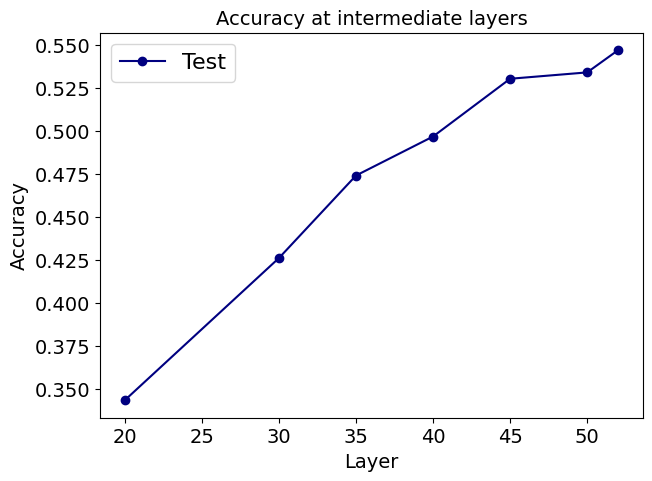

In [ ]:
#
# self ensembling
#


class BatchNormLinear(nn.Module):
    def __init__(self, in_features, out_features, device="cuda"):
        super(BatchNormLinear, self).__init__()
        self.batch_norm = nn.BatchNorm1d(in_features, device=device)
        self.linear = nn.Linear(in_features, out_features, device=device)

    def forward(self, x):
        x = self.batch_norm(x)
        return self.linear(x)


class WrapModelForResNet152(torch.nn.Module):
    def __init__(self, model, multichannel_fn, classes=10):
        super(WrapModelForResNet152, self).__init__()

        self.multichannel_fn = multichannel_fn

        self.model = model

        self.classes = classes

        self.layer_operations = [
            torch.nn.Sequential(
                model.conv1,
                model.bn1,
                model.relu,
                model.maxpool,
            ),
            *model.layer1,
            *model.layer2,
            *model.layer3,
            *model.layer4,
            model.avgpool,
            model.fc,
        ]

        self.all_dims = [
            3 * 224 * 224 * len(resolutions),
            64 * 56 * 56,
            *[256 * 56 * 56] * len(model.layer1),
            *[512 * 28 * 28] * len(model.layer2),
            *[1024 * 14 * 14] * len(model.layer3),
            *[2048 * 7 * 7] * len(model.layer4),
            2048,
            1000,
        ]

        self.linear_layers = torch.nn.ModuleList([BatchNormLinear(self.all_dims[i], classes, device="cuda") for i in range(len(self.all_dims))])

    def prepare_input(self, x):
        x = self.multichannel_fn(x)
        x = F.interpolate(x, size=(224, 224), mode="bicubic")
        x = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406] * (x.shape[1] // 3), std=[0.229, 0.224, 0.225] * (x.shape[1] // 3))(x)
        return x

    def forward_until(self, x, layer_id):
        x = self.prepare_input(x)

        for l in range(layer_id):
            if list(x.shape)[1:] == [2048, 1, 1]:
                x = x.reshape([-1, 2048])

            x = self.layer_operations[l](x)
        return x

    def forward_after(self, x, layer_id):
        x = self.prepare_input(x)

        for l in range(layer_id, len(self.layer_operations)):
            if list(x.shape)[1:] == [2048, 1, 1]:
                x = x.reshape([-1, 2048])

            x = self.layer_operations[l](x)
        return x

    def predict_from_layer(self, x, l):
        x = self.forward_until(x, l)
        x = x.reshape([x.shape[0], -1])
        return self.linear_layers[l](x)

    def predict_from_several_layers(self, x, layers):
        x = self.prepare_input(x)

        outputs = dict()

        outputs[0] = self.linear_layers[0](x.reshape([x.shape[0], -1]))

        for l in range(len(self.layer_operations)):
            if list(x.shape)[1:] == [2048, 1, 1]:
                x = x.reshape([-1, 2048])

            x = self.layer_operations[l](x)

            if l in layers:
                outputs[l + 1] = self.linear_layers[l + 1](x.reshape([x.shape[0], -1]))

        return outputs


resnet152_wrapper = WrapModelForResNet152(model.imported_model, make_multichannel_input, classes=classes)
resnet152_wrapper.multichannel_fn = make_multichannel_input

# del model # for memory reasons
resnet152_wrapper = resnet152_wrapper.to("cuda")
assert all([resnet152_wrapper.predict_from_layer(torch.Tensor(np.zeros((2, 3, 32, 32))).cuda(), layer_i).shape == torch.Size([2, 100]) for layer_i in range(53)])


class LinearNet(nn.Module):
    def __init__(self, model, layer_i):
        super(LinearNet, self).__init__()
        self.model = model
        self.layer_i = layer_i

    def forward(self, inputs):
        return self.model.predict_from_layer(inputs, self.layer_i)


backbone_model = copy.deepcopy(resnet152_wrapper)
del resnet152_wrapper

# only training some layers to save time -- super early ones are badon anything harder than CIFAR-10
layers_to_use = [20, 30, 35, 40, 45, 50, 52]

lr = 3.3e-5  # random stuff again
epochs = 1
batch_size = 64  # for CUDA RAM reasons

mode = "train"
backbone_model.eval()

linear_model = LinearNet(backbone_model, 5).to("cuda")  # just to have it ready

torch.cuda.empty_cache()

device = torch.device("cuda:0")

linear_layers_collected_dict = dict()

for layer_i in reversed(layers_to_use):
    print(f"///////// layer={layer_i} ///////////")

    linear_model.layer_i = layer_i
    linear_model.fixed_mode = "train"

    train_accs = []
    test_accs = []
    robust_accs = []
    clean_accs = []
    actual_robust_accs = []

    all_models = []

    torch.cuda.empty_cache()

    linear_model = train_model(
        linear_model,
        images_train_np[:],
        labels_train_np[:],
        epochs=epochs,
        lr=lr,
        optimizer_in=optim.Adam,
        batch_size=batch_size,
        mode=mode,
        subset_only=linear_model.model.linear_layers[layer_i].parameters(),  # just the linear projection
        use_adversarial_training=False,
        adversarial_epsilon=None,
    )

    linear_layers_collected_dict[layer_i] = copy.deepcopy(backbone_model.linear_layers[layer_i])

for layer_i in layers_to_use:
    print(f"layer={layer_i}")
    backbone_model.linear_layers[layer_i] = copy.deepcopy(linear_layers_collected_dict[layer_i])
    print(f"Done with {layer_i}.")

del all_models
del linear_layers_collected_dict

backbone_model.cuda()
backbone_model.eval()

test_acc_by_layer = []
for layer_i in layers_to_use:
    linear_model = LinearNet(backbone_model, layer_i).to("cuda")
    linear_model.eval()
    test_hits, test_count, _ = eval_model(linear_model, images_test_np, labels_test_np)
    test_acc_by_layer.append(test_hits / test_count)
    print(f"layer={layer_i} test={test_hits}/{test_count}={test_hits/test_count}")

test_acc_by_layer = []
for layer_i in layers_to_use:
    linear_model = LinearNet(backbone_model, layer_i).to("cuda")
    linear_model.eval()
    test_hits, test_count, _ = eval_model(linear_model, images_test_np, labels_test_np)
    test_acc_by_layer.append(test_hits / test_count)
    print(f"layer={layer_i} test={test_hits}/{test_count}={test_hits/test_count}")

plt.figure(figsize=(7, 5), dpi=100)
plt.title("Accuracy at intermediate layers", fontsize=14)
plt.plot(layers_to_use, test_acc_by_layer, marker="o", color="navy", label="Test")
plt.legend(fontsize=16)
plt.xlabel("Layer", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

torch.Size([32, 3, 32, 32])
torch.Size([32])
torch.Size([32, 3, 32, 32])


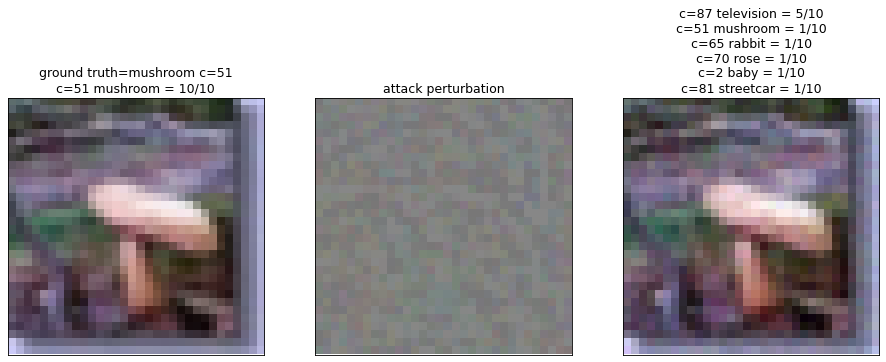

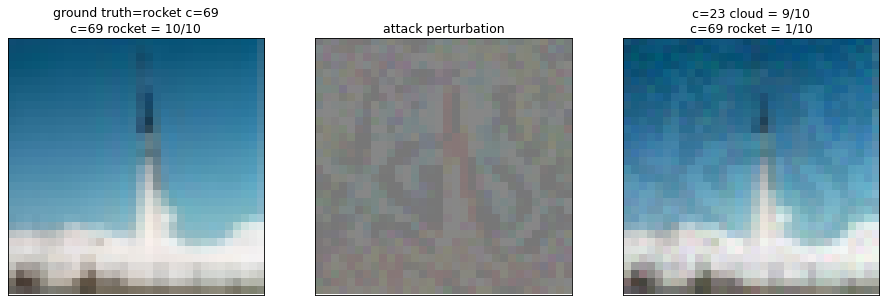

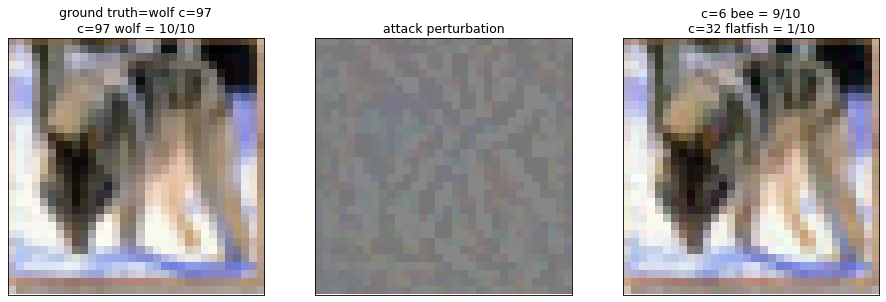

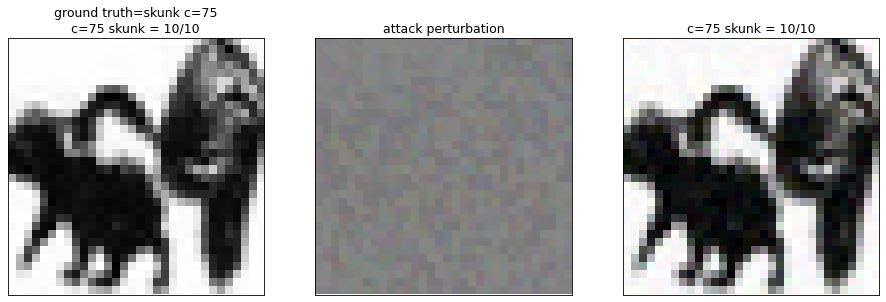

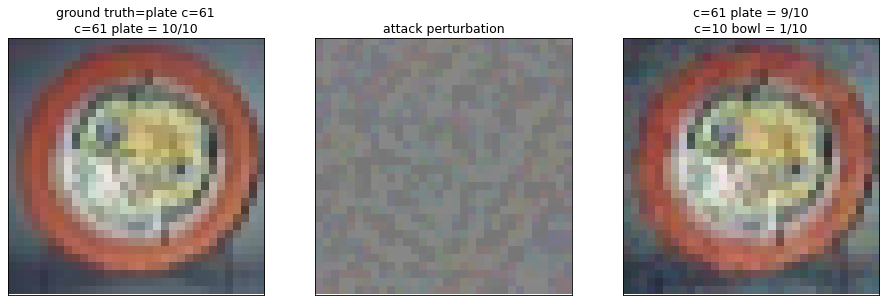

In [ ]:
#
# robustbench eval (takes 16min)
#


class WrappedCombinedModel(torch.nn.Module):
    def __init__(self, model):
        super(WrappedCombinedModel, self).__init__()
        self.model = model

    def forward(self, x):
        all_logits = self.model.model.predict_from_several_layers(x, [l - 1 for l in [0, 1, 5, 10, 20, 30, 35, 40, 45, 50, 52][1:]])
        all_logits[54] = self.model.model.model(self.model.model.prepare_input(x))  # adding the prediction of the backbone itself
        all_logits = torch.stack([all_logits[l] for l in [20, 30, 35, 40, 45, 50, 52, 54]], axis=1)
        all_logits = all_logits - torch.max(all_logits, axis=2, keepdims=True).values
        all_logits = all_logits - torch.max(all_logits, axis=1, keepdims=True).values
        logits = torch.topk(all_logits, 3, axis=1).values[:, 2]
        return logits


wrapped_combined_model = WrappedCombinedModel(linear_model)
wrapped_combined_model(torch.Tensor(np.zeros((1, 3, 32, 32))).cuda()).shape

test_hits, test_count, _ = eval_model(wrapped_combined_model, images_test_np, labels_test_np)
print(f"test={test_hits}/{test_count}={test_hits/test_count}")
self_ensemble_test_acc = test_hits / test_count

import warnings
from argparse import Namespace
from pathlib import Path
from typing import Callable, Dict, Optional, Sequence, Tuple, Union

import numpy as np
import pandas as pd
import torch
import random
from autoattack import AutoAttack
from autoattack.state import EvaluationState
from torch import nn
from tqdm import tqdm

from robustbench.data import CORRUPTIONS_DICT, get_preprocessing, load_clean_dataset, CORRUPTION_DATASET_LOADERS
from robustbench.model_zoo.enums import BenchmarkDataset, ThreatModel
from robustbench.utils import clean_accuracy, load_model, parse_args, update_json
from robustbench.model_zoo import model_dicts as all_models


def benchmark(
    model: Union[nn.Module, Sequence[nn.Module]],
    n_examples: int = 10000,
    dataset: Union[str, BenchmarkDataset] = BenchmarkDataset.cifar_10,
    threat_model: Union[str, ThreatModel] = ThreatModel.Linf,
    to_disk: bool = False,
    model_name: Optional[str] = None,
    data_dir: str = "./data",
    corruptions_data_dir: Optional[str] = None,
    device: Optional[Union[torch.device, Sequence[torch.device]]] = None,
    batch_size: int = 32,
    eps: Optional[float] = None,
    log_path: Optional[str] = None,
    version="custom",  #'rand', # 'rand' for models using stochasticity
    preprocessing: Optional[Union[str, Callable]] = None,
    aa_state_path: Optional[Path] = None,
    # stan's additional sections for explicitly choosing test set images to use
    id_start=None,
    id_stop=None,
) -> Tuple[float, float]:
    """Benchmarks the given model(s).

    It is possible to benchmark on 3 different threat models, and to save the results on disk. In
    the future benchmarking multiple models in parallel is going to be possible.

    :param model: The model to benchmark.
    :param n_examples: The number of examples to use to benchmark the model.
    :param dataset: The dataset to use to benchmark. Must be one of {cifar10, cifar100}
    :param threat_model: The threat model to use to benchmark, must be one of {L2, Linf
    corruptions}
    :param to_disk: Whether the results must be saved on disk as .json.
    :param model_name: The name of the model to use to save the results. Must be specified if
    to_json is True.
    :param data_dir: The directory where the dataset is or where the dataset must be downloaded.
    :param device: The device to run the computations.
    :param batch_size: The batch size to run the computations. The larger, the faster the
    evaluation.
    :param eps: The epsilon to use for L2 and Linf threat models. Must not be specified for
    corruptions threat model.
    :param preprocessing: The preprocessing that should be used for ImageNet benchmarking. Should be
    specified if `dataset` is `imageget`.
    :param aa_state_path: The path where the AA state will be saved and from where should be
    loaded if it already exists. If `None` no state will be used.

    :return: A Tuple with the clean accuracy and the accuracy in the given threat model.
    """
    if isinstance(model, Sequence) or isinstance(device, Sequence):
        # Multiple models evaluation in parallel not yet implemented
        raise NotImplementedError

    try:
        if model.training:
            warnings.warn(Warning("The given model is *not* in eval mode."))
    except AttributeError:
        warnings.warn(Warning("It is not possible to asses if the model is in eval mode"))

    dataset_: BenchmarkDataset = BenchmarkDataset(dataset)
    threat_model_: ThreatModel = ThreatModel(threat_model)

    device = device or torch.device("cpu")
    model = model.to(device)

    prepr = get_preprocessing(dataset_, threat_model_, model_name, preprocessing)

    clean_x_test, clean_y_test = load_clean_dataset(dataset_, n_examples, data_dir, prepr)

    if id_start is not None and id_stop is not None:
        clean_x_test = clean_x_test[id_start:id_stop]
        clean_y_test = clean_y_test[id_start:id_stop]
        # taking a subset of the images
        print(f"using {len(clean_x_test)} images in the range {id_start} to {id_stop}")

    accuracy = clean_accuracy(model, clean_x_test, clean_y_test, batch_size=batch_size, device=device)
    print(f"Clean accuracy: {accuracy:.2%}")

    extra_metrics = {}  # dict to store corruptions_mce for corruptions threat models
    if threat_model_ in {ThreatModel.Linf, ThreatModel.L2}:
        if eps is None:
            raise ValueError("If the threat model is L2 or Linf, `eps` must be specified.")

        adversary = AutoAttack(
            model,
            norm=threat_model_.value,
            eps=eps,
            version=version,
            device=device,
            log_path=log_path,
            attacks_to_run=["apgd-ce", "apgd-t"] if version == "custom" else [],  # Stan's addition
        )
        x_adv = adversary.run_standard_evaluation(clean_x_test, clean_y_test, bs=batch_size, state_path=aa_state_path)
        if aa_state_path is None:
            adv_accuracy = clean_accuracy(model, x_adv, clean_y_test, batch_size=batch_size, device=device)
        else:
            aa_state = EvaluationState.from_disk(aa_state_path)
            assert aa_state.robust_flags is not None
            adv_accuracy = aa_state.robust_flags.mean().item()

    elif threat_model_ in [ThreatModel.corruptions, ThreatModel.corruptions_3d]:
        corruptions = CORRUPTIONS_DICT[dataset_][threat_model_]
        print(f"Evaluating over {len(corruptions)} corruptions")
        # Exceptionally, for corruptions (2d and 3d) we use only resizing to 224x224
        prepr = get_preprocessing(dataset_, threat_model_, model_name, "Res224")
        # Save into a dict to make a Pandas DF with nested index
        corruptions_data_dir = corruptions_data_dir or data_dir
        adv_accuracy, adv_mce = corruptions_evaluation(batch_size, corruptions_data_dir, dataset_, threat_model_, device, model, n_examples, to_disk, prepr, model_name)

        extra_metrics["corruptions_mce"] = adv_mce
    else:
        raise NotImplementedError
    print(f"Adversarial accuracy: {adv_accuracy:.2%}")

    if to_disk:
        if model_name is None:
            raise ValueError("If `to_disk` is True, `model_name` should be specified.")

        update_json(dataset_, threat_model_, model_name, accuracy, adv_accuracy, eps, extra_metrics)

    data = (clean_x_test, clean_y_test, x_adv)
    return accuracy, adv_accuracy, data


device = torch.device("cuda:0")

print(f"Self-ensemble test acc = {self_ensemble_test_acc}")
print("\n---------------------------------------------\n")

t1 = time.time()

with isolated_environment():
    clean_acc, robust_acc, data_out = benchmark(
        wrapped_combined_model.eval(),
        dataset=f"cifar{classes}",
        threat_model="Linf",
        device=device,
        eps=8 / 255,
        n_examples=32,  # 32 images to have it done quick
        version="rand",
        batch_size=32,
    )

t2 = time.time()
print(f"Time taken = {int(t2-t1)} seconds")


def cifar100_class_to_description(class_num):
    classes = [
        "apple",
        "aquarium fish",
        "baby",
        "bear",
        "beaver",
        "bed",
        "bee",
        "beetle",
        "bicycle",
        "bottle",
        "bowl",
        "boy",
        "bridge",
        "bus",
        "butterfly",
        "camel",
        "can",
        "castle",
        "caterpillar",
        "cattle",
        "chair",
        "chimpanzee",
        "clock",
        "cloud",
        "cockroach",
        "couch",
        "crab",
        "crocodile",
        "cup",
        "dinosaur",
        "dolphin",
        "elephant",
        "flatfish",
        "forest",
        "fox",
        "girl",
        "hamster",
        "house",
        "kangaroo",
        "keyboard",
        "lamp",
        "lawn mower",
        "leopard",
        "lion",
        "lizard",
        "lobster",
        "man",
        "maple tree",
        "motorcycle",
        "mountain",
        "mouse",
        "mushroom",
        "oak tree",
        "orange",
        "orchid",
        "otter",
        "palm tree",
        "pear",
        "pickup truck",
        "pine tree",
        "plain",
        "plate",
        "poppy",
        "porcupine",
        "possum",
        "rabbit",
        "raccoon",
        "ray",
        "road",
        "rocket",
        "rose",
        "sea",
        "seal",
        "shark",
        "shrew",
        "skunk",
        "skyscraper",
        "snail",
        "snake",
        "spider",
        "squirrel",
        "streetcar",
        "sunflower",
        "sweet pepper",
        "table",
        "tank",
        "telephone",
        "television",
        "tiger",
        "tractor",
        "train",
        "trout",
        "tulip",
        "turtle",
        "wardrobe",
        "whale",
        "willow tree",
        "wolf",
        "woman",
        "worm",
    ]

    if 0 <= class_num < len(classes):
        return classes[class_num]
    else:
        return "Invalid class number"


from collections import Counter


def count_and_sort_frequencies(lst):
    # Count occurrences of each number
    counter = Counter(lst)

    # Sort items by frequency in descending order
    sorted_items = counter.most_common()

    # Print the sorted items
    for number, frequency in sorted_items:
        print(f"{number}: {frequency}")


reps = 10

for clean_xs, clean_ys, adv_xs in [data_out]:
    clean_xs = clean_xs.cuda()
    clean_ys = clean_ys.cuda()
    adv_xs = adv_xs.cuda()

    print(clean_xs.shape)
    print(clean_ys.shape)
    print(adv_xs.shape)

    all_clean_pred_argmaxes = []
    for r in range(reps):
        with torch.no_grad():
            logits = wrapped_combined_model(clean_xs).detach().cpu().numpy()
        pred_argmaxes = np.argmax(logits, axis=-1)
        all_clean_pred_argmaxes.append(pred_argmaxes)

    all_pred_argmaxes = []
    for r in range(reps):
        with torch.no_grad():
            logits = wrapped_combined_model(adv_xs).detach().cpu().numpy()
        pred_argmaxes = np.argmax(logits, axis=-1)
        all_pred_argmaxes.append(pred_argmaxes)

    for i in range(len(clean_xs)):
        if np.sum(clean_xs[i].detach().cpu().numpy() - adv_xs[i].detach().cpu().numpy()) > 0:
            plt.figure(figsize=(3 * 5, 5), dpi=75)

            plt.subplot(1, 3, 1)
            vals = [pred_argmaxes[i] for pred_argmaxes in all_clean_pred_argmaxes]
            vals_sorted, freqs_sorted = zip(*Counter(vals).most_common())
            plt.xticks([], [])
            plt.yticks([], [])

            title = f"ground truth={cifar100_class_to_description(clean_ys[i])} c={clean_ys[i]}\n"
            for j in range(len(vals_sorted)):
                title = title + f"c={vals_sorted[j]} {cifar100_class_to_description(vals_sorted[j]) } = {freqs_sorted[j]}/{reps}\n"
            plt.title(title[:-1])

            plt.imshow(adv_xs[i].detach().cpu().numpy().transpose([1, 2, 0]))

            plt.imshow(clean_xs[i].detach().cpu().numpy().transpose([1, 2, 0]))

            plt.subplot(1, 3, 3)
            vals = [pred_argmaxes[i] for pred_argmaxes in all_pred_argmaxes]
            vals_sorted, freqs_sorted = zip(*Counter(vals).most_common())
            plt.xticks([], [])
            plt.yticks([], [])

            title = ""
            for j in range(len(vals_sorted)):
                title = title + f"c={vals_sorted[j]} {cifar100_class_to_description(vals_sorted[j]) } = {freqs_sorted[j]}/{reps}\n"
            plt.title(title[:-1])

            plt.imshow(adv_xs[i].detach().cpu().numpy().transpose([1, 2, 0]))

            plt.subplot(1, 3, 2)
            plt.title("attack perturbation")
            plt.imshow(0.5 + clean_xs[i].detach().cpu().numpy().transpose([1, 2, 0]) - adv_xs[i].detach().cpu().numpy().transpose([1, 2, 0]))
            plt.xticks([], [])
            plt.yticks([], [])

            plt.show()